In [1]:
import random
random.seed(1)

import numpy as np
np.random.seed(1)

import itertools
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf

### pointwise, pairwise and listwise approach

The listwise approach addresses the ranking problem in a more straightforward way. Specifically, it takes ranking lists as instances in both learning and prediction. The group structure of ranking is maintained and ranking evaluation measures can be more directly incorporated into the loss functions in learning.

ListNet allows us to construct our ranking task in such a way that decreasing its loss values more directly impacts our “true” objective (for example, increasing Normalised Discounted Cumulative Gain or Mean Average Precision).

### Permutation Probability

In [2]:
objects_to_rank = {"dress", "shirt", "pants"}

all_permutations = list(itertools.permutations(objects_to_rank))
for x in sorted(all_permutations):
  print(x)

('dress', 'pants', 'shirt')
('dress', 'shirt', 'pants')
('pants', 'dress', 'shirt')
('pants', 'shirt', 'dress')
('shirt', 'dress', 'pants')
('shirt', 'pants', 'dress')


In [3]:
scores_dict = {x: np.random.randn(1)[0] for x in ["shirt", "pants", "dress"]}

print(scores_dict)

{'shirt': 1.6243453636632417, 'pants': -0.6117564136500754, 'dress': -0.5281717522634557}


In [4]:
pi = random.choice(all_permutations)
print(pi)

('pants', 'shirt', 'dress')


In [5]:
obj_pos_1, obj_pos_2, obj_pos_3 = pi
print(f"object at position 1 is '{obj_pos_1}'")
print(f"object at position 2 is '{obj_pos_2}'")
print(f"object at position 3 is '{obj_pos_3}'")


object at position 1 is 'pants'
object at position 2 is 'shirt'
object at position 3 is 'dress'


In [6]:
score_obj_pos_1 = scores_dict[obj_pos_1]
score_obj_pos_2 = scores_dict[obj_pos_2]
score_obj_pos_3 = scores_dict[obj_pos_3]

In [7]:
first_term_numerator = np.exp(score_obj_pos_1)
first_term_denominator = np.exp(score_obj_pos_1) + np.exp(score_obj_pos_2) + np.exp(score_obj_pos_3)

first_term = first_term_numerator / first_term_denominator

print(f"first term is {first_term}")

first term is 0.08738232042105001


In [8]:
second_term_numerator = np.exp(score_obj_pos_2)
second_term_denominator = np.exp(score_obj_pos_2) + np.exp(score_obj_pos_3)

second_term = second_term_numerator / second_term_denominator

print(f"second term is {second_term}")

second term is 0.8959037576952953


In [9]:
third_term = 1.0

In [10]:
prob_of_permutation = first_term * second_term * third_term

print(f"probability of permutation is {prob_of_permutation}")

probability of permutation is 0.07828614922135305


The scores sorted in descending order have the highest permutation probability.

The scores sorted in ascending order have the lowest permutation probability.

### Top One Probability

In [11]:
np.exp(scores_dict['shirt']) / sum(np.exp(list(scores_dict.values())))

0.8176176084739423

### Converting scores and relevance labels into the probability distribution

In [13]:
scores_dict

{'shirt': 1.6243453636632417,
 'pants': -0.6117564136500754,
 'dress': -0.5281717522634557}

In [15]:
ordered_scores = np.array([scores_dict[x] for x in scores_dict.keys()]).astype(np.float32)
predicted_prob_dist = tf.nn.softmax(ordered_scores)

print(predicted_prob_dist)

tf.Tensor([0.8176176  0.08738231 0.09500005], shape=(3,), dtype=float32)


In [17]:
raw_relevance_grades = tf.constant([3.0, 1.0, 0.0], dtype=tf.float32)
true_prob_dist = tf.nn.softmax(raw_relevance_grades)

print(true_prob_dist)

tf.Tensor([0.8437947  0.11419519 0.04201007], shape=(3,), dtype=float32)


### KL-Divergence

If we have two separate probability distributions
P
(
X
)
 and
Q
(
X
)
 over the same random variable
X
, we can measure how diﬀerent these two distributions are using the Kullback-Leibler (KL) divergence.

The KL divergence is
0
 if and only if
P
 and
Q
 are the same distribution in the case of discrete variables.

In [18]:
sum(true_prob_dist * np.log(true_prob_dist / predicted_prob_dist))

<tf.Tensor: shape=(), dtype=float32, numpy=0.022873335>

In [19]:
sum(true_prob_dist * np.log(true_prob_dist / true_prob_dist))


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Neural Network

In [20]:
query_1 = "dog"

bing_search_results = [
    "Dog - Wikipedia",
    "Adopting a dog or puppy | RSPCA Australia",
    "dog | History, Domestication, Physical Traits, & Breeds",
    "New South Wales | Dogs & Puppies | Gumtree Australia Free",
    "dog - Wiktionary"
]

In [21]:
query_2 = "what is a dog"

google_search_results = [
    "Dog - Wikipedia",
    "Dog - Simple English Wikipedia, the free encyclopedia",
    "Dog | National Geographic",
    "dog | History, Domestication, Physical Traits, & Breeds",
    "What is a Dog | Facts About Dogs | DK Find Out"
]

In [22]:
relevance_grades = tf.constant([
    [3.0, 2.0, 2.0, 2.0, 1.0],
    [3.0, 3.0, 1.0, 1.0, 0.0]
])

In [23]:
combined_texts = [query_1, *bing_search_results, *google_search_results]

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(combined_texts)

vocab_size = max(tokenizer.index_word) + 1
print(vocab_size)

35


In [24]:
for idx, word in tokenizer.index_word.items():
  print(f"index {idx} - {word}")

index 1 - dog
index 2 - wikipedia
index 3 - a
index 4 - australia
index 5 - history
index 6 - domestication
index 7 - physical
index 8 - traits
index 9 - breeds
index 10 - dogs
index 11 - free
index 12 - adopting
index 13 - or
index 14 - puppy
index 15 - rspca
index 16 - new
index 17 - south
index 18 - wales
index 19 - puppies
index 20 - gumtree
index 21 - wiktionary
index 22 - simple
index 23 - english
index 24 - the
index 25 - encyclopedia
index 26 - national
index 27 - geographic
index 28 - what
index 29 - is
index 30 - facts
index 31 - about
index 32 - dk
index 33 - find
index 34 - out


In [25]:
EMBEDDING_DIMS = 2
embeddings = np.random.randn(vocab_size, EMBEDDING_DIMS).astype(np.float32)
print(embeddings)

[[-1.0729686   0.86540765]
 [-2.3015387   1.7448118 ]
 [-0.7612069   0.3190391 ]
 [-0.24937038  1.4621079 ]
 [-2.0601406  -0.3224172 ]
 [-0.38405436  1.1337694 ]
 [-1.0998913  -0.1724282 ]
 [-0.8778584   0.04221375]
 [ 0.58281523 -1.1006192 ]
 [ 1.1447237   0.9015907 ]
 [ 0.50249434  0.90085596]
 [-0.68372786 -0.12289023]
 [-0.93576944 -0.26788807]
 [ 0.53035545 -0.69166076]
 [-0.39675352 -0.6871727 ]
 [-0.84520566 -0.6712461 ]
 [-0.0126646  -1.1173104 ]
 [ 0.2344157   1.6598022 ]
 [ 0.74204415 -0.19183555]
 [-0.887629   -0.7471583 ]
 [ 1.6924546   0.05080776]
 [-0.6369957   0.19091548]
 [ 2.1002553   0.12015896]
 [ 0.6172031   0.30017033]
 [-0.35224986 -1.1425182 ]
 [-0.34934273 -0.20889424]
 [ 0.5866232   0.8389834 ]
 [ 0.9311021   0.2855873 ]
 [ 0.8851412  -0.7543979 ]
 [ 1.2528682   0.5129298 ]
 [-0.29809284  0.48851815]
 [-0.07557172  1.1316293 ]
 [ 1.5198169   2.1855755 ]
 [-1.3964963  -1.4441139 ]
 [-0.5044659   0.16003707]]


In [27]:
query_1_embedding_index = tokenizer.texts_to_sequences([query_1])
query_1_embeddings = np.array([embeddings[x] for x in query_1_embedding_index])

print(query_1_embeddings)

[[[-2.3015387  1.7448118]]]


In [30]:
query_2_embedding_indices = tokenizer.texts_to_sequences([query_2])
query_2_embeddings = np.array([embeddings[x] for x in query_2_embedding_indices])

print(query_2_embeddings)

[[[ 0.8851412  -0.7543979 ]
  [ 1.2528682   0.5129298 ]
  [-0.24937038  1.4621079 ]
  [-2.3015387   1.7448118 ]]]


In [31]:
query_2_embedding_indices

[[28, 29, 3, 1]]

In [32]:
query_2_embeddings_avg = tf.reduce_mean(query_2_embeddings, axis=1, keepdims=True).numpy()
print(query_2_embeddings_avg)

[[[-0.10322493  0.74136287]]]


In [33]:
query_embeddings = np.row_stack([query_1_embeddings, query_2_embeddings_avg])
print(query_embeddings.shape)

(2, 1, 2)


In [34]:
docs_sequences = []
for docs_list in [bing_search_results, google_search_results]:
    docs_sequences.append(tokenizer.texts_to_sequences(docs_list))

docs_embeddings = []
for docs_set in docs_sequences:
    this_docs_set = []
    for doc in docs_set:
        this_doc_embeddings = np.array([embeddings[idx] for idx in doc])
        this_docs_set.append(this_doc_embeddings)
    docs_embeddings.append(this_docs_set)

In [35]:
for embeddings in docs_embeddings[0]:
    print()
    print(embeddings)


[[-2.3015387  1.7448118]
 [-0.7612069  0.3190391]]

[[-0.93576944 -0.26788807]
 [-0.24937038  1.4621079 ]
 [-2.3015387   1.7448118 ]
 [ 0.53035545 -0.69166076]
 [-0.39675352 -0.6871727 ]
 [-0.84520566 -0.6712461 ]
 [-2.0601406  -0.3224172 ]]

[[-2.3015387   1.7448118 ]
 [-0.38405436  1.1337694 ]
 [-1.0998913  -0.1724282 ]
 [-0.8778584   0.04221375]
 [ 0.58281523 -1.1006192 ]
 [ 1.1447237   0.9015907 ]]

[[-0.0126646  -1.1173104 ]
 [ 0.2344157   1.6598022 ]
 [ 0.74204415 -0.19183555]
 [ 0.50249434  0.90085596]
 [-0.887629   -0.7471583 ]
 [ 1.6924546   0.05080776]
 [-2.0601406  -0.3224172 ]
 [-0.68372786 -0.12289023]]

[[-2.3015387   1.7448118 ]
 [-0.6369957   0.19091548]]


In [36]:
for embeddings in docs_embeddings[1]:
    print()
    print(embeddings)


[[-2.3015387  1.7448118]
 [-0.7612069  0.3190391]]

[[-2.3015387   1.7448118 ]
 [ 2.1002553   0.12015896]
 [ 0.6172031   0.30017033]
 [-0.7612069   0.3190391 ]
 [-0.35224986 -1.1425182 ]
 [-0.68372786 -0.12289023]
 [-0.34934273 -0.20889424]]

[[-2.3015387  1.7448118]
 [ 0.5866232  0.8389834]
 [ 0.9311021  0.2855873]]

[[-2.3015387   1.7448118 ]
 [-0.38405436  1.1337694 ]
 [-1.0998913  -0.1724282 ]
 [-0.8778584   0.04221375]
 [ 0.58281523 -1.1006192 ]
 [ 1.1447237   0.9015907 ]]

[[ 0.8851412  -0.7543979 ]
 [ 1.2528682   0.5129298 ]
 [-0.24937038  1.4621079 ]
 [-2.3015387   1.7448118 ]
 [-0.29809284  0.48851815]
 [-0.07557172  1.1316293 ]
 [ 0.50249434  0.90085596]
 [ 1.5198169   2.1855755 ]
 [-1.3964963  -1.4441139 ]
 [-0.5044659   0.16003707]]


In [37]:
docs_averaged_embeddings = []
for docs_set in docs_embeddings:
    this_docs_set = []
    for doc in docs_set:
        this_docs_set.append(tf.reduce_mean(doc, axis=0, keepdims=True))
    concatenated_docs_set = tf.concat(this_docs_set, axis=0).numpy()
    docs_averaged_embeddings.append(concatenated_docs_set)

docs_averaged_embeddings = np.array(docs_averaged_embeddings)

In [38]:
print(docs_averaged_embeddings.shape)

(2, 5, 2)


In [39]:
NUM_DOCS_PER_QUERY = 5

expanded_queries = tf.gather(query_embeddings, [0 for x in range(NUM_DOCS_PER_QUERY)], axis=1).numpy()

print(expanded_queries)

[[[-2.3015387   1.7448118 ]
  [-2.3015387   1.7448118 ]
  [-2.3015387   1.7448118 ]
  [-2.3015387   1.7448118 ]
  [-2.3015387   1.7448118 ]]

 [[-0.10322493  0.74136287]
  [-0.10322493  0.74136287]
  [-0.10322493  0.74136287]
  [-0.10322493  0.74136287]
  [-0.10322493  0.74136287]]]


In [40]:
expanded_batch = np.concatenate([expanded_queries, docs_averaged_embeddings], axis=-1)

print(expanded_batch)

[[[-2.3015387   1.7448118  -1.5313728   1.0319254 ]
  [-2.3015387   1.7448118  -0.89406043  0.08093353]
  [-2.3015387   1.7448118  -0.4893006   0.42488968]
  [-2.3015387   1.7448118  -0.05909418  0.01373178]
  [-2.3015387   1.7448118  -1.4692671   0.9678636 ]]

 [[-0.10322493  0.74136287 -1.5313728   1.0319254 ]
  [-0.10322493  0.74136287 -0.24722967  0.14426823]
  [-0.10322493  0.74136287 -0.26127115  0.9564608 ]
  [-0.10322493  0.74136287 -0.4893006   0.42488968]
  [-0.10322493  0.74136287 -0.06652153  0.6387954 ]]]


In [42]:
expanded_batch.shape

(2, 5, 4)

### The hidden layers

In [41]:
dense_1 = tf.keras.layers.Dense(units=3, activation="relu")
dense_1_out = dense_1(expanded_batch)

print(dense_1_out)

tf.Tensor(
[[[0.24037245 0.         0.        ]
  [0.21703063 0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.22968955 0.         0.        ]]

 [[0.49399328 0.         1.0092198 ]
  [0.14470261 0.         0.11269107]
  [0.         0.         0.63391995]
  [0.17725326 0.         0.35389432]
  [0.         0.         0.38129956]]], shape=(2, 5, 3), dtype=float32)


In [43]:
scores = tf.keras.layers.Dense(units=1, activation="linear")
scores_out = scores(dense_1_out)
print(scores_out)

tf.Tensor(
[[[ 0.00143875]
  [ 0.00129904]
  [ 0.        ]
  [ 0.        ]
  [ 0.00137481]]

 [[-1.2233244 ]
  [-0.13606238]
  [-0.7702625 ]
  [-0.4289484 ]
  [-0.46330887]]], shape=(2, 5, 1), dtype=float32)


### Calculate the KL Divergence in the context of our expanded batch

In [44]:
scores_for_softmax = tf.squeeze(scores_out, axis=-1)
scores_for_softmax.shape

TensorShape([2, 5])

In [45]:
scores_prob_dist = tf.nn.softmax(scores_for_softmax, axis=-1)
print(scores_prob_dist)

tf.Tensor(
[[0.20012324 0.20009528 0.19983551 0.19983551 0.20011044]
 [0.10110576 0.29989403 0.15905167 0.22375308 0.21619542]], shape=(2, 5), dtype=float32)


In [46]:
relevance_grades_prob_dist = tf.nn.softmax(relevance_grades, axis=-1)
print(relevance_grades_prob_dist)

tf.Tensor(
[[0.44663328 0.1643072  0.1643072  0.1643072  0.06044524]
 [0.4309495  0.4309495  0.05832267 0.05832267 0.02145571]], shape=(2, 5), dtype=float32)


In [47]:
loss = tf.keras.losses.KLDivergence()
batch_loss = loss(relevance_grades_prob_dist, scores_prob_dist)
print(batch_loss)

tf.Tensor(0.3920213, shape=(), dtype=float32)


In [48]:
per_example_loss = tf.reduce_sum(
    relevance_grades_prob_dist * tf.math.log(relevance_grades_prob_dist / scores_prob_dist),
    axis=-1
)

print(per_example_loss)

tf.Tensor([0.1894922  0.59455043], shape=(2,), dtype=float32)


In [49]:
batch_loss = tf.reduce_mean(per_example_loss)

print(batch_loss)

tf.Tensor(0.3920213, shape=(), dtype=float32)


### Toy ListNet Implemenation

In [50]:
NUM_DOCS_PER_QUERY = 5
EMBEDDING_DIMS = 2

In [52]:
class ExpandBatchLayer(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(ExpandBatchLayer, self).__init__(**kwargs)

  def call(self, input):
    queries, docs = input
    batch, num_docs, embedding_dims = tf.unstack(tf.shape(docs))
    expanded_queries = tf.gather(queries, tf.zeros([num_docs], tf.int32), axis=1)
    return tf.concat([expanded_queries, docs], axis=-1)

In [53]:
query_input = tf.keras.layers.Input(shape=(1, EMBEDDING_DIMS, ), dtype=tf.float32, name='query')
docs_input = tf.keras.layers.Input(shape=(NUM_DOCS_PER_QUERY, EMBEDDING_DIMS, ), dtype=tf.float32,
                name='docs')

expand_batch = ExpandBatchLayer(name='expand_batch')
dense_1 = tf.keras.layers.Dense(units=3, activation='linear', name='dense_1')
dense_out = tf.keras.layers.Dense(units=1, activation='linear', name='scores')
scores_prob_dist = tf.keras.layers.Dense(units=NUM_DOCS_PER_QUERY, activation='softmax',
                      name='scores_prob_dist')

expanded_batch = expand_batch([query_input, docs_input])
dense_1_out = dense_1(expanded_batch)
scores = tf.keras.layers.Flatten()(dense_out(dense_1_out))
model_out = scores_prob_dist(scores)

model = tf.keras.models.Model(inputs=[query_input, docs_input], outputs=[model_out])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.03, momentum=0.9),
              loss=tf.keras.losses.KLDivergence())

In [54]:
hist = model.fit(
    [query_embeddings, docs_averaged_embeddings],
    relevance_grades_prob_dist,
    epochs=50,
    verbose=False
)

In [56]:
hist.history

{'loss': [1.046555519104004,
  0.7101724147796631,
  0.4600779414176941,
  0.4645574688911438,
  0.5008984804153442,
  0.4324790835380554,
  0.3036092519760132,
  0.19578395783901215,
  0.1308339387178421,
  0.09736201912164688,
  0.08334185183048248,
  0.08069726079702377,
  0.08295682817697525,
  0.08468672633171082,
  0.08280783146619797,
  0.07745455950498581,
  0.07087121903896332,
  0.06532793492078781,
  0.06185048818588257,
  0.060242798179388046,
  0.05971231311559677,
  0.05942176654934883,
  0.05875733867287636,
  0.05738326907157898,
  0.055197738111019135,
  0.05226438492536545,
  0.0487525537610054,
  0.04489313066005707,
  0.04094618558883667,
  0.037172019481658936,
  0.033803798258304596,
  0.031016428023576736,
  0.02889849618077278,
  0.02743447944521904,
  0.026504896581172943,
  0.02591295912861824,
  0.025432752445340157,
  0.02486734837293625,
  0.024095414206385612,
  0.02309158444404602,
  0.02191227301955223,
  0.02065913751721382,
  0.019433975219726562,
  0.

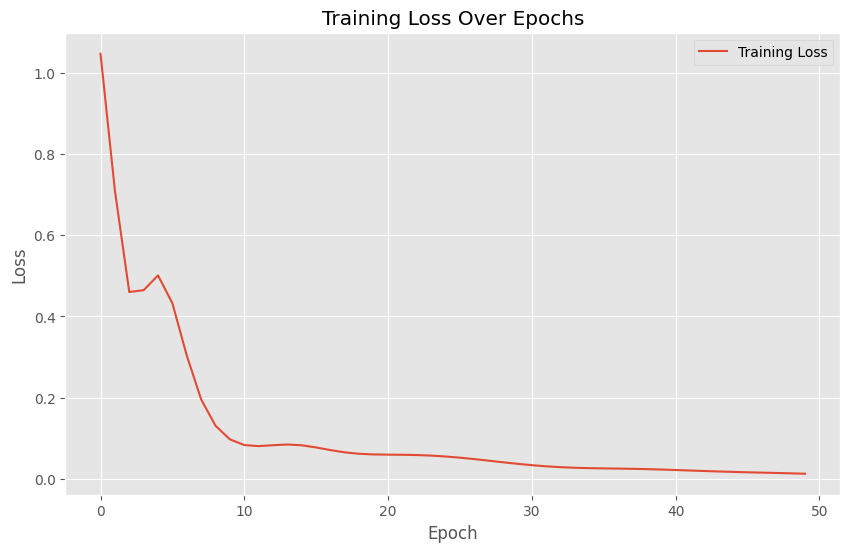

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()